In [ ]:
# Recommendation model using Graph neural network that recommends courses to students based on their curosity and behaviour 

In [1]:


from google.colab import drive
drive.mount('/content/drive')


Mounted at /content/drive


In [3]:
!pip install optuna
!pip install torch-geometric


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 380.1/380.1 kB 16.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 233.0/233.0 kB 16.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 78.6/78.6 kB 4.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 64.2/64.2 kB 4.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.1/1.1 MB 47.7 MB/s eta 0:00:00


In [4]:
import pandas as pd
import numpy as np
import torch
import torch.nn.functional as F
from torch_geometric.data import Data
from torch_geometric.nn import SAGEConv, GATConv, GCNConv
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.model_selection import train_test_split
import optuna
from sklearn.neighbors import NearestNeighbors
from torch_geometric.utils import to_undirected

In [5]:
# Load and preprocess the dataset
df = pd.read_csv(r'/content/drive/MyDrive/xAPI-Edu-Data.csv')
label_encoders = {}
for column in df.select_dtypes(include=['object']).columns:
    le = LabelEncoder()
    df[column] = le.fit_transform(df[column])
    label_encoders[column] = le

features = df.drop(columns=['Class'])
labels = df['Class']

scaler = StandardScaler()
features = scaler.fit_transform(features)

# Split data
train_features, test_features, train_labels, test_labels = train_test_split(
    features, labels, test_size=0.2, random_state=42
)

train_features = torch.tensor(train_features, dtype=torch.float)
test_features = torch.tensor(test_features, dtype=torch.float)
train_labels = torch.tensor(train_labels.values, dtype=torch.long)
test_labels = torch.tensor(test_labels.values, dtype=torch.long)



In [6]:
import numpy as np
import torch

def create_edge_index_corr(features, threshold=0.4):
    corr_matrix = np.corrcoef(features, rowvar=False)
    edges = np.where(np.abs(corr_matrix) > threshold)
    edge_index = torch.tensor(edges, dtype=torch.long)
    edge_index = to_undirected(edge_index)
    return edge_index

train_edge_index = create_edge_index_corr(train_features)
test_edge_index = create_edge_index_corr(test_features)

train_data = Data(x=train_features, edge_index=train_edge_index, y=train_labels)
test_data = Data(x=test_features, edge_index=test_edge_index, y=test_labels)


<ipython-input-6-27154d74578a>:7: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at ../torch/csrc/utils/tensor_new.cpp:274.)
  edge_index = torch.tensor(edges, dtype=torch.long)


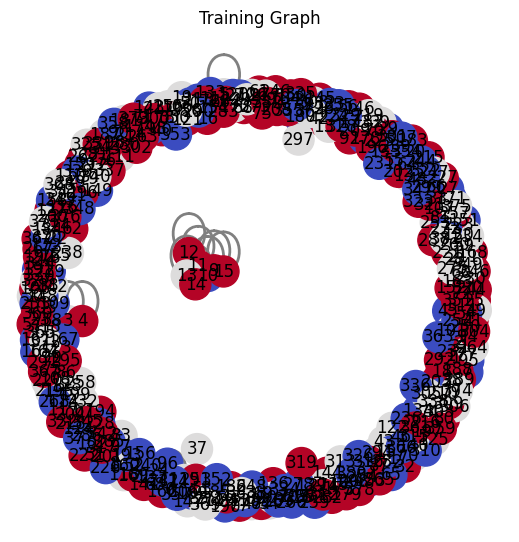

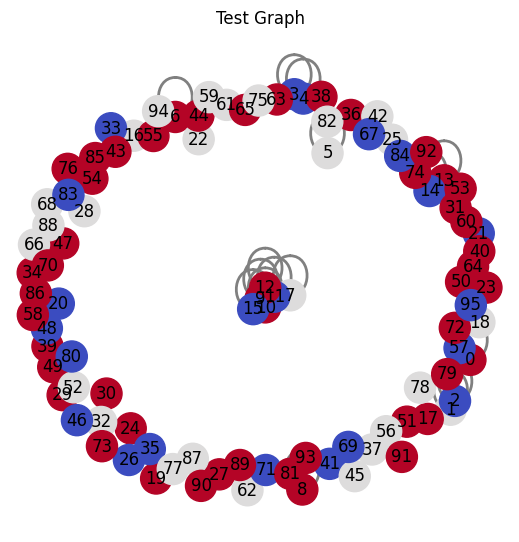

In [7]:
from torch_geometric.utils import to_undirected, to_networkx
import networkx as nx
import matplotlib.pyplot as plt
# Visualize the graph using NetworkX
def visualize_graph(data, title="Graph Visualization"):
    G = to_networkx(data, to_undirected=True)
    plt.figure(figsize=(5, 5))
    pos = nx.spring_layout(G, k=0.15, iterations=50) # Positioning of nodes
    nx.draw(G, pos, with_labels=True, node_color=data.y.numpy(), cmap=plt.get_cmap('coolwarm'), node_size=500, edge_color='gray', width=2)
    plt.title(title)
    plt.show()

# Visualize train and test graphs
visualize_graph(train_data, title="Training Graph")
visualize_graph(test_data, title="Test Graph")

In [8]:
# Define GNN Model
class AdvancedGNN(torch.nn.Module):
    def __init__(self, in_channels, out_channels, hidden_dim=64, heads=8):
        super(AdvancedGNN, self).__init__()
        self.conv1 = SAGEConv(in_channels, hidden_dim)
        self.bn1 = torch.nn.BatchNorm1d(hidden_dim)
        self.dropout = torch.nn.Dropout(0.5)
        self.conv2 = GATConv(hidden_dim, hidden_dim, heads=heads, concat=True)
        self.conv3 = GCNConv(hidden_dim * heads, out_channels)

    def forward(self, x, edge_index):
        x = F.relu(self.bn1(self.conv1(x, edge_index)))
        x = self.dropout(x)
        x, attention_weights = self.conv2(x, edge_index, return_attention_weights=True)
        x = self.conv3(x, edge_index)
        return F.log_softmax(x, dim=1), attention_weights



In [9]:
# Define Objective Function
def objective(trial, train_features, train_labels, test_features, test_labels):
    hidden_dim = trial.suggest_int('hidden_dim', 32, 128)
    dropout_rate = trial.suggest_float('dropout_rate', 0.3, 0.7)
    heads = trial.suggest_int('heads', 3, 16)

    model = AdvancedGNN(in_channels=train_features.size(1), out_channels=len(torch.unique(train_labels)), hidden_dim=hidden_dim, heads=heads)
    optimizer = torch.optim.Adam(model.parameters(), lr=0.01)

    model.train()
    for epoch in range(100):
        optimizer.zero_grad()
        logits, _ = model(train_features, train_edge_index)
        loss = F.nll_loss(logits, train_labels)
        loss.backward()
        optimizer.step()

    model.eval()
    with torch.no_grad():
        logits = model(test_features, test_edge_index)[0]
        pred = logits.argmax(dim=1)
        accuracy = (pred == test_labels).sum().item() / test_labels.size(0)

    return accuracy

In [10]:
# Optimize hyperparameters
study = optuna.create_study(direction="maximize")
study.optimize(lambda trial: objective(trial, train_features, train_labels, test_features, test_labels), n_trials=50)

# Get the best hyperparameters from the optimization
best_params = study.best_params
print(f"Best Hyperparameters: {best_params}")

# Initialize the model with the best hyperparameters
best_model = AdvancedGNN(in_channels=train_features.size(1), out_channels=len(torch.unique(train_labels)),
                         hidden_dim=best_params['hidden_dim'],
                         heads=best_params['heads'])

# Set up the optimizer
optimizer = torch.optim.Adam(best_model.parameters(), lr=0.001)

# Train the model with the best hyperparameters
best_model.train()
for epoch in range(100):
    optimizer.zero_grad()
    logits, _ = best_model(train_features, train_edge_index)
    loss = F.nll_loss(logits, train_labels)
    loss.backward()
    optimizer.step()

# Evaluate the model
best_model.eval()
with torch.no_grad():
    logits = best_model(test_features, test_edge_index)[0]
    pred = logits.argmax(dim=1)
    accuracy = (pred == test_labels).sum().item() / test_labels.size(0)
    print(f"Final Model Accuracy: {accuracy:.4f}")


[I 2024-08-18 04:49:04,736] A new study created in memory with name: no-name-92b57733-5503-4d3e-9886-2ef0313cf5a8
[I 2024-08-18 04:49:06,669] Trial 0 finished with value: 0.78125 and parameters: {'hidden_dim': 105, 'dropout_rate': 0.5680561372317015, 'heads': 3}. Best is trial 0 with value: 0.78125.
[I 2024-08-18 04:49:08,617] Trial 1 finished with value: 0.8229166666666666 and parameters: {'hidden_dim': 89, 'dropout_rate': 0.30832825368111566, 'heads': 7}. Best is trial 1 with value: 0.8229166666666666.
[I 2024-08-18 04:49:10,461] Trial 2 finished with value: 0.8020833333333334 and parameters: {'hidden_dim': 83, 'dropout_rate': 0.5326614677535947, 'heads': 13}. Best is trial 1 with value: 0.8229166666666666.
[I 2024-08-18 04:49:11,534] Trial 3 finished with value: 0.8020833333333334 and parameters: {'hidden_dim': 113, 'dropout_rate': 0.38324365433227636, 'heads': 4}. Best is trial 1 with value: 0.8229166666666666.
[I 2024-08-18 04:49:12,375] Trial 4 finished with value: 0.791666666666

Best Hyperparameters: {'hidden_dim': 94, 'dropout_rate': 0.36026956360883355, 'heads': 3}
Final Model Accuracy: 0.8125
